In [1]:
import pandas as pd
import numpy as np
from factor_backtest import preprocess
from factor_backtest import group_calc
from factor_backtest import factor_analysis
from factor_backtest import utils
import polars as pl

In [2]:
# index = pd.read_csv('../data/index_stocks/index_ZZ500_stocks.csv', index_col=0)
# index['trade_date'].unique(),len(index['trade_date'].unique())

# 载入数据

In [3]:
# 读取数据
factor_df=pl.read_csv('../data/trend_support_volume_factor.csv').to_pandas()
bp_df = pd.read_csv('../data/pb.csv')
ret_df=pd.read_csv('../data/ret_df.csv')
mktmv_df = pd.read_csv('../data/ltsz.csv')
benchmark = pd.read_csv('../data/index_ret.csv')
ind_df=pd.read_csv('../data/ind_df.csv')
# 处理股票代码
codefunc1=lambda x: '{:0>6}'.format(x)
factor_df['stock_code']=factor_df['code'].apply(codefunc1)
bp_df['stock_code']=bp_df['stock_code'].apply(codefunc1)
ret_df['stock_code']=ret_df['stock_code'].apply(codefunc1)
# mktmv_df['stock_code']=mktmv_df['stock_code'].apply(codefunc1)
ind_df['stock_code']=ind_df['stock_code'].apply(codefunc1)
# 处理日期
codefunc2 = lambda x: x if pd.isna(x) else str(int(x))
factor_df['trade_date'] = pd.to_datetime(factor_df['date'], format='%Y-%m-%d')
## 转为‘%Y%m%d’
factor_df['trade_date'] = factor_df['trade_date'].dt.strftime('%Y%m%d')
# factor_df['trade_date']=factor_df['trade_date'].apply(codefunc2)
## ret_df['trade_date']转为 日期格式 
ret_df['trade_date'] = pd.to_datetime(ret_df['trade_date'], format='%Y-%m-%d')
## 转为‘%Y%m%d’
ret_df['trade_date'] = ret_df['trade_date'].dt.strftime('%Y%m%d')
ret_df['trade_date']=ret_df['trade_date'].apply(codefunc2)
mktmv_df['trade_date']=mktmv_df['trade_date'].apply(codefunc2)


bp_df['trade_date']=bp_df['trade_date'].apply(codefunc2)

ind_df['trade_date'] = pd.to_datetime(ind_df['trade_date'], format='%Y-%m-%d')
## 转为‘%Y%m%d’
ind_df['trade_date'] = ind_df['trade_date'].dt.strftime('%Y%m%d')
ind_df['trade_date']=ind_df['trade_date'].apply(codefunc2)
benchmark['trade_date'] = benchmark['trade_date'].apply(codefunc2)
# ind_df

# 预处理

In [4]:
factor_df = factor_df.dropna()
## drop 0
# factor_df = factor_df[factor_df['factor']!=0]
factor_df = utils.get_previous_factor(factor_df)
factor_df

,trade_date,date,code,factor_3,stock_code
0,20140213,2014-02-12,000001.SZ,-2.257421,000001.SZ
1,20140213,2014-02-12,000002.SZ,0.497873,000002.SZ
2,20140213,2014-02-12,000004.SZ,-2.130212,000004.SZ
3,20140213,2014-02-12,000005.SZ,0.608253,000005.SZ
4,20140213,2014-02-12,000006.SZ,-2.025187,000006.SZ
...,...,...,...,...,...
6714917,20151014,2015-10-13,603979.SH,-2.479579,603979.SH
6714918,20151014,2015-10-13,603989.SH,-25.932663,603989.SH
6714919,20151014,2015-10-13,603993.SH,-6.484182,603993.SH
6714920,20151014,2015-10-13,603997.SH,5.307767,603997.SH


In [5]:
factor_df['factor'] = factor_df['factor_3']#- factor_df['sum_放_阳大长上短下']

In [6]:
mktmv_df = mktmv_df.dropna()
mktmv_df = utils.get_previous_factor(mktmv_df)

# mktmv_df

In [7]:
# bp_df = bp_df.dropna()
# bp_df

In [8]:
# 处理factor因子
# MAD去极值
factor_df = preprocess.select_stock(factor_df,index_name = None,drop_hk = True,drop_bj = True)
factor_df = factor_df[['trade_date', 'stock_code', 'factor']]
# factor_df['factor'] = - factor_df['factor']
factor_df = preprocess.del_outlier(factor_df, 'factor', method='mad', n=3)
# # 排序标准化
# factor_df = preprocess.standardize(factor_df, 'factor', method='rank')
# # 同时做市值中性化和行业中性化
# factor_df=preprocess.neutralize(factor_df=factor_df,
#                                  factor_name='factor',
#                                  mktmv_df=mktmv_df,
#                                  industry_df=ind_df)

factor_df

,trade_date,stock_code,factor
0,20140213,000001.SZ,-2.257421
1,20140213,000002.SZ,0.497873
2,20140213,000004.SZ,-2.130212
3,20140213,000005.SZ,0.608253
4,20140213,000006.SZ,-2.025187
...,...,...,...
6714917,20151014,603979.SH,-2.479579
6714918,20151014,603989.SH,-16.073264
6714919,20151014,603993.SH,-6.484182
6714920,20151014,603997.SH,5.307767


In [9]:
factor_df['trade_date'].unique(),len(factor_df['trade_date'].unique())

(array(['20140213', '20140214', '20140217', ..., '20151012', '20151013',
        '20151014'], dtype=object),
 2429)

# 分组收益率计算

In [10]:
mw_group_ret = group_calc.get_group_ret(factor_df, ret_df, 'factor', 10, None)
mw_group_ret

d:\onedrive - cuhk-shenzhen\量化研究\factor_backtest-main\base\src\factor_backtest\group_calc.py:118: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(["trade_date", group_name])


,Group0,Group1,Group2,Group3,Group4,Group5,Group6,Group7,Group8,Group9,H-L
20140214,0.024691,0.022770,0.020103,0.018300,0.016517,0.017710,0.014491,0.014310,0.020613,0.021112,-0.003579
20140217,0.029328,0.026557,0.018032,0.019336,0.016128,0.014575,0.017180,0.014095,0.014833,0.022214,-0.007114
20140218,0.002830,0.001181,0.002485,-0.002458,-0.001189,-0.004963,-0.005452,-0.003409,-0.001555,0.001904,-0.000926
20140219,-0.004613,0.001712,0.000772,0.002326,0.002508,0.003927,0.006336,0.006700,0.004489,0.000874,0.005487
20140220,-0.021091,-0.017319,-0.017168,-0.013585,-0.014563,-0.012207,-0.009603,-0.009992,-0.009143,-0.017698,0.003393
...,...,...,...,...,...,...,...,...,...,...,...
20240123,0.000425,0.002024,0.002820,0.003351,0.006046,0.005037,0.006123,0.005796,0.006144,0.003871,0.003446
20240124,0.019253,0.018071,0.017437,0.020845,0.020421,0.021149,0.019770,0.018035,0.021419,0.017573,-0.001680
20240125,0.031120,0.035880,0.038914,0.036750,0.037902,0.035501,0.036932,0.036370,0.037035,0.036551,0.005431
20240126,-0.001445,0.002317,0.002656,0.003482,0.003592,0.003913,0.003745,0.001925,0.002549,-0.001614,-0.000169


# 因子分析

In [11]:
mw_group_ret = mw_group_ret.dropna()

In [12]:
factor_analysis.newy_west_test(mw_group_ret['H-L'],'factor')

{'factor_name': ['factor'],
 'ret_mean(%)': [0.047],
 't-value': [4.081],
 'p-value': [0.0],
 'p-star': ['***']}

# IC检验

In [13]:
ic_dct, ic_fig = factor_analysis.analysis_factor_ic(factor_df, ret_df, 'factor')
pd.DataFrame(ic_dct)


,因子名称,IC均值,IC标准差,IR比率,IC>0的比例(%),IC>0.02的比例(%)
0,factor,0.005794,0.071407,0.081134,52.759473,41.515651


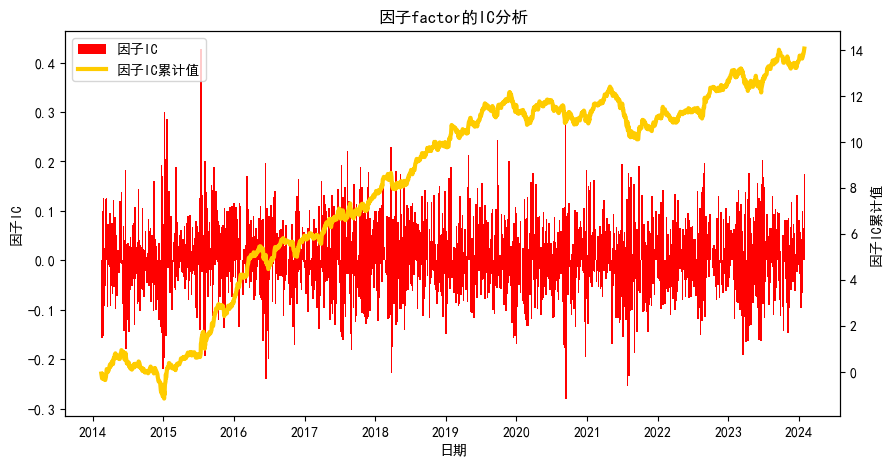

In [14]:
ic_fig

# RankIC 检验

In [15]:
rank_ic_dct, rank_ic_fig = factor_analysis.analysis_factor_rank_ic(factor_df, ret_df, 'factor')
pd.DataFrame(rank_ic_dct)

,因子名称,RankIC均值,RankIC标准差,RankIR比率,RankIC>0的比例(%),RankIC>0.02的比例(%)
0,factor,0.022794,0.080484,0.283206,62.438221,51.771005


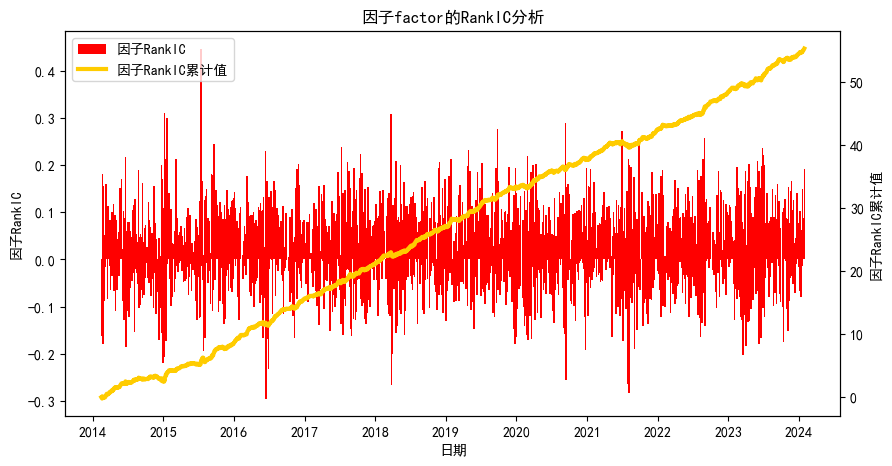

In [16]:
rank_ic_fig

# 净值曲线

In [17]:
ew_backtest_df,ew_fig1,ew_fig2=group_calc.analysis_group_ret(factor_df, ret_df, 'factor', n_groups=10, benchmark=None, mktmv_df=None)
ew_backtest_df

d:\onedrive - cuhk-shenzhen\量化研究\factor_backtest-main\base\src\factor_backtest\group_calc.py:118: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(["trade_date", group_name])


,Group0,Group1,Group2,Group3,Group4,Group5,Group6,Group7,Group8,Group9,H-L
年化收益率(%),-7.333120,10.166358,14.038145,15.042174,16.234331,17.991616,19.273061,17.214352,17.045527,4.881614,12.216104
年化波动率(%),31.897430,29.390085,28.267894,27.444826,26.600832,26.108925,25.819969,26.318540,27.841387,30.309638,8.329661
夏普比率,-0.229897,0.345911,0.496611,0.548088,0.610294,0.689098,0.746440,0.654077,0.612237,0.161058,1.466579
最大回撤(%),-83.036936,-69.157690,-58.843692,-56.431000,-51.000770,-50.392558,-51.212244,-51.622539,-53.074377,-63.054514,-15.164250


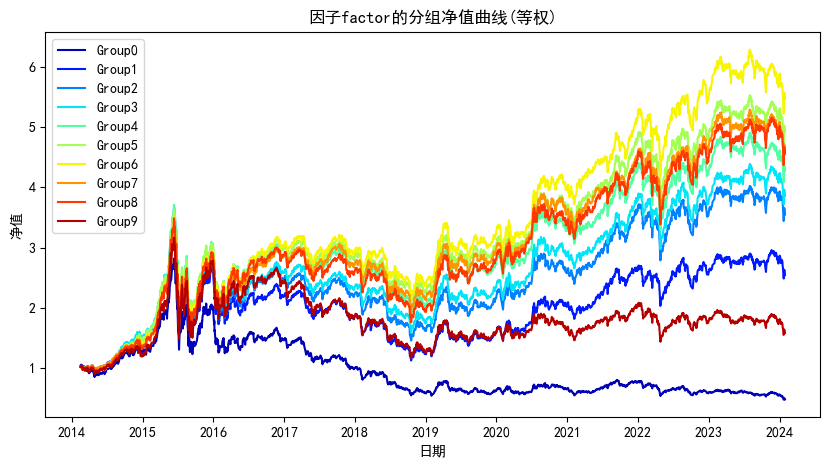

In [18]:
ew_fig1

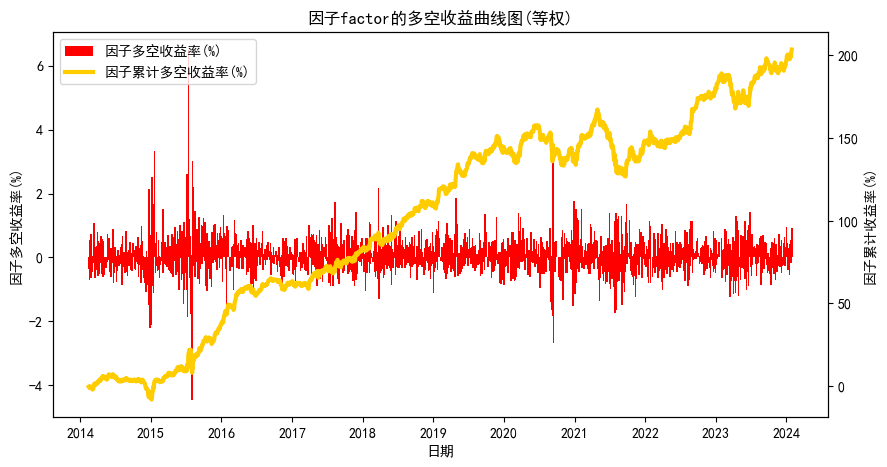

In [19]:
ew_fig2

In [20]:
mw_backtest_df,mw_fig1,mw_fig2=group_calc.analysis_group_ret(factor_df, ret_df, 'factor', n_groups=10, mktmv_df=mktmv_df)
mw_backtest_df

d:\onedrive - cuhk-shenzhen\量化研究\factor_backtest-main\base\src\factor_backtest\group_calc.py:118: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(["trade_date", group_name])


,Group0,Group1,Group2,Group3,Group4,Group5,Group6,Group7,Group8,Group9,H-L
年化收益率(%),-15.298193,0.340247,1.783809,6.650829,8.510351,11.950487,14.543868,13.269062,7.788101,-1.192186,15.106105
年化波动率(%),31.493535,28.775630,27.273111,25.529441,24.693619,23.131444,22.664853,22.586098,26.158827,29.883600,12.810516
夏普比率,-0.485757,0.011824,0.065405,0.260516,0.344638,0.516634,0.641693,0.587488,0.297724,-0.039894,1.179196
最大回撤(%),-91.100203,-77.533899,-72.966736,-58.574254,-46.079381,-45.272292,-46.619323,-41.996376,-56.883057,-64.831128,-28.533762


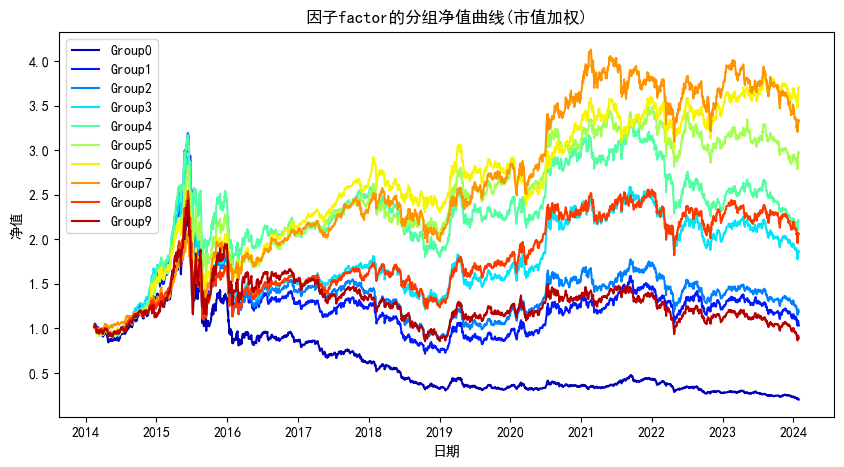

In [21]:
mw_fig1

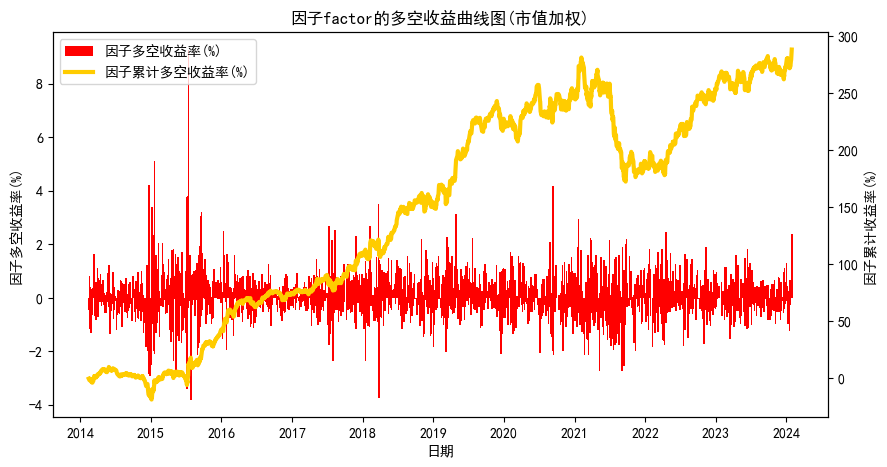

In [22]:
mw_fig2

# 序贯双重排序

In [23]:
db_sort_group_ret = group_calc.get_double_sort_group_ret(
    bp_df,
    factor_df,
    ret_df,
    "bp",
    "factor",
    5,
    5,
    mktmv_df=mktmv_df,
)
db_sort_group_ret

ValueError: The columns of df must be var_lst:trade_date, stock_code, bp

In [ ]:
db_sort_mean_df = group_calc.double_sort_mean(db_sort_group_ret,"bp","factor")
db_sort_mean_df

Group0  Group1  Group2  Group3  Group4    H-L
Group0 ret_mean(%)  -0.016   0.034   0.052   0.062   0.119  0.135
       t-value      -0.538   0.301   1.327   2.109   1.446  3.161
Group1 ret_mean(%)  -0.023   0.011   0.045   0.075   0.060  0.082
       t-value      -0.387   0.655   1.034   2.063   2.315  4.694
Group2 ret_mean(%)  -0.016   0.024   0.033   0.069   0.089  0.104
       t-value      -0.370   0.402   1.419   1.723   2.631  5.166
Group3 ret_mean(%)  -0.016   0.016   0.055   0.063   0.104  0.120
       t-value      -0.913   0.828   1.767   1.623   2.635  5.986
Group4 ret_mean(%)  -0.040   0.034   0.067   0.063   0.107  0.146
       t-value      -0.406   1.021   1.504   1.621   2.494  4.716

In [ ]:
db_sort_backtest_df = group_calc.double_sort_backtest(db_sort_group_ret, "bp", "factor", benchmark=None, period="DAILY")
db_sort_backtest_df

Group0     Group1     Group2     Group3     Group4  \
Group0 年化收益率(%)  -7.436262   5.512445  10.361937  12.803682  28.989756   
       年化波动率(%)  27.071767  24.762032  25.486265  26.767197  30.220327   
       夏普比率      -0.274687   0.222617   0.406569   0.478335   0.959280   
       最大回撤(%)  -78.391544 -52.160429 -42.243271 -57.900955 -56.252165   
Group1 年化收益率(%)  -9.298901  -0.601984   8.598528  16.892260  11.357437   
       年化波动率(%)  28.393189  25.751979  24.286369  25.831422  29.349082   
       夏普比率      -0.327505  -0.023376   0.354047   0.653942   0.386978   
       最大回撤(%)  -83.312118 -67.489785 -45.986533 -47.784046 -52.546035   
Group2 年化收益率(%)  -7.568670   2.722847   5.770138  15.522539  20.347373   
       年化波动率(%)  28.026229  25.492258  23.527802  23.983286  27.333020   
       夏普比率      -0.270057   0.106811   0.245248   0.647223   0.744425   
       最大回撤(%)  -82.147144 -58.063365 -55.361540 -41.922520 -42.561671   
Group3 年化收益率(%)  -8.073216   0.075626  10.755262  13.411939  25.109939   
       年化波动率(%)  29.598119  28.012199  26.611420  25.643610  27.321074   
       夏普比率      -0.272761   0.002700   0.404160   0.523013   0.919069   
       最大回撤(%)  -80.150841 -72.603460 -49.604616 -45.991029 -38.621724   
Group4 年化收益率(%) -13.697476   4.508260  14.076080  13.187578  25.929859   
       年化波动率(%)  30.409841  28.443554  27.036484  26.672636  27.429556   
       夏普比率      -0.450429   0.158498   0.520633   0.494423   0.945325   
       最大回撤(%)  -93.056377 -66.207721 -55.835640 -53.215407 -43.467738   

                       H-L  
Group0 年化收益率(%)  37.899654  
       年化波动率(%)  19.774921  
       夏普比率       1.916552  
       最大回撤(%)  -17.851882  
Group1 年化收益率(%)  21.258026  
       年化波动率(%)  17.307382  
       夏普比率       1.228264  
       最大回撤(%)  -36.355467  
Group2 年化收益率(%)  28.524221  
       年化波动率(%)  14.859551  
       夏普比率       1.919588  
       最大回撤(%)  -22.850264  
Group3 年化收益率(%)  33.603688  
       年化波动率(%)  15.403356  
       夏普比率       2.181582  
       最大回撤(%)  -21.593425  
Group4 年化收益率(%)  42.715454  
       年化波动率(%)  16.237084  
       夏普比率       2.630734  
       最大回撤(%)  -30.650307

# Fama-Macbeth回归

In [ ]:
two_factor_df = pd.merge(factor_df, bp_df, on=['trade_date', 'stock_code'])
fmreg_res_dct = factor_analysis.fama_macbeth_reg(ret_df, two_factor_df, ['factor', 'bp'])
fmreg_res_dct

AssertionError: 

In [ ]:
ret_df

,trade_date,stock_code,ret
0,20100104,000001.SZ,-0.027085
1,20100105,000001.SZ,-0.017292
2,20100106,000001.SZ,-0.017169
3,20100107,000001.SZ,-0.010921
4,20100108,000001.SZ,-0.002207
...,...,...,...
14627603,20250122,9997.HK,0.013333
14627604,20250123,9997.HK,-0.001645
14627605,20250124,9997.HK,0.028007
14627606,20250127,9997.HK,0.022436


In [ ]:
two_factor_df

,trade_date,stock_code,factor,bp
0,20140129,000001.SZ,0.023419,0.006025
1,20140130,000001.SZ,0.057419,-0.131192
2,20140207,000001.SZ,0.076329,-0.031149
3,20140210,000001.SZ,-0.179076,0.025837
4,20140211,000001.SZ,-0.168375,0.065413
...,...,...,...,...
7194986,20221212,688981.SH,1.156058,0.895736
7194987,20221213,688981.SH,0.886304,0.889854
7194988,20221214,688981.SH,0.691800,0.882755
7194989,20221215,688981.SH,0.637557,0.900426
